In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import matplotlib

In [165]:
class kohonen:
    def __init__(self, N,M, dataset, width, architecture):
        self.M=M
        self.N=N
        self.dataset = dataset
        self.neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M,dataset.shape[1]))
        self.width = width
        self.epochs = 0
        if architecture == "hexagon":
            self.dist = self.dist_hex
        else:
            self.dist = self.dist_rec
    
    def learn(self,lambda_, method="gauss"):
        
        self.epochs += lambda_
        
        if method == "mexican":
            neighbor_function = self.mexican_hat
        else:
            neighbor_function = self.gauss
        for iteration in range(lambda_):
            p = np.random.permutation(len(self.dataset))
            x = self.dataset[p]
            for inp in x:
                minimal_pos = np.argmin([np.linalg.norm(neuron-inp) for neuron in self.neurons])
                for i,neuron in enumerate(self.neurons):
                    self.neurons[i] = neuron + neighbor_function(self.dist(self,minimal_pos,i),self.epochs + iteration - lambda_)*self.alpha_fun(self.epochs + iteration - lambda_,self.epochs)*(inp-neuron)
    
    def classify(self):
        return [np.argmin([np.linalg.norm(neuron-inp) for neuron in self.neurons]) for inp in self.dataset]
    
    def limit_neurons(self, n):
        while (len(self.neurons) > n):
            distance = np.array([np.linalg.norm(i-j) for i in self.neurons for j in self.neurons])
            distance = distance[distance!=0]
            distance = distance.reshape(len(self.neurons),len(self.neurons)-1)
            index = np.unravel_index(distance.argmin(), distance.shape)[0]
            self.neurons = np.delete(self.neurons,index,0)

    
    @staticmethod
    def dist_rec(self,x,y):
        a = self.width*((x%self.N-y%self.N))
        b = self.width*(math.floor(x/self.N)-math.floor(y/self.N))
        
        return math.sqrt(a**2 + b**2)
    
    @staticmethod
    def dist_hex(self,x,y):
        a = self.width*((x%self.N-y%self.N))
        b = self.width*(math.floor(x/self.N)-math.floor(y/self.N))
        
        if (math.floor(x/self.N)-math.floor(y/self.N))%2==0: 
            a += 1/2
        return math.sqrt(a**2 + b**2)
    
    @staticmethod
    def alpha_fun(iteration,lambda_):
        return math.exp(-iteration/lambda_)
    
    @staticmethod
    def gauss(x,t):
        return math.exp(-(x*t)**2)
    
    @staticmethod
    def mexican_hat(x):
        return math.exp(-x**2) * (2-4*x**2)

In [160]:
dataset = pd.read_csv('hexagon.csv')

dataset=(dataset-dataset.mean())/dataset.std()

x = np.asarray(dataset.iloc[:,[0,1]])

In [161]:
dataset

,x,y,c
0,1.062342,0.864828,-0.877578
1,-0.295702,1.622945,-1.462630
2,0.973993,-0.533979,-0.292526
3,1.407005,0.605579,-0.877578
4,1.404405,-0.478782,-0.292526
...,...,...,...
595,-0.972584,-0.914454,0.877578
596,1.810830,-0.644791,-0.292526
597,-1.339913,-0.632203,0.877578
598,1.658544,0.698785,-0.877578


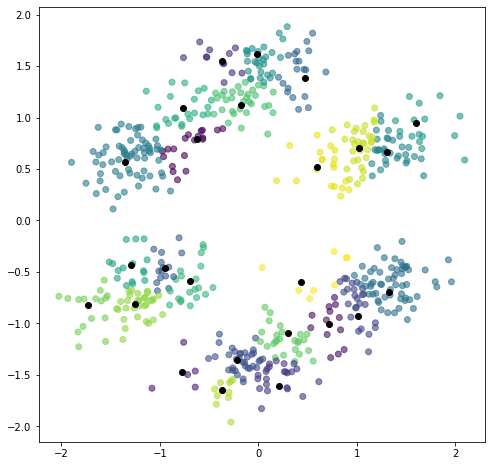

In [170]:
koh = kohonen(5,5,x,1, architecture = "rectangle")

fig = plt.figure(figsize=(8,8))


koh.learn(lambda_=100, method="gauss")
c = koh.classify()

plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.6)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")

In [ ]:
koh.limit_neurons(6)
c = koh.classify()

plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.6)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")

In [171]:
def count_clustering_scores(X, cluster_num, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = kohonen(4,3,x,1, architecture = "rectangle")
        model_instance.learn(lambda_=100, method="gauss")
        model_instance.limit_neurons(k)
        labels = model_instance.classify()
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [ ]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 11) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(x, cluster_num_seq, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

In [64]:
def to_dict(c):
    unique, counts = np.unique(c, return_counts=True)
    data = dict(zip(unique, counts))
    data = {k: data[k] for k in sorted(data, key=data.get, reverse=True)}
    return data

<BarContainer object of 9 artists>

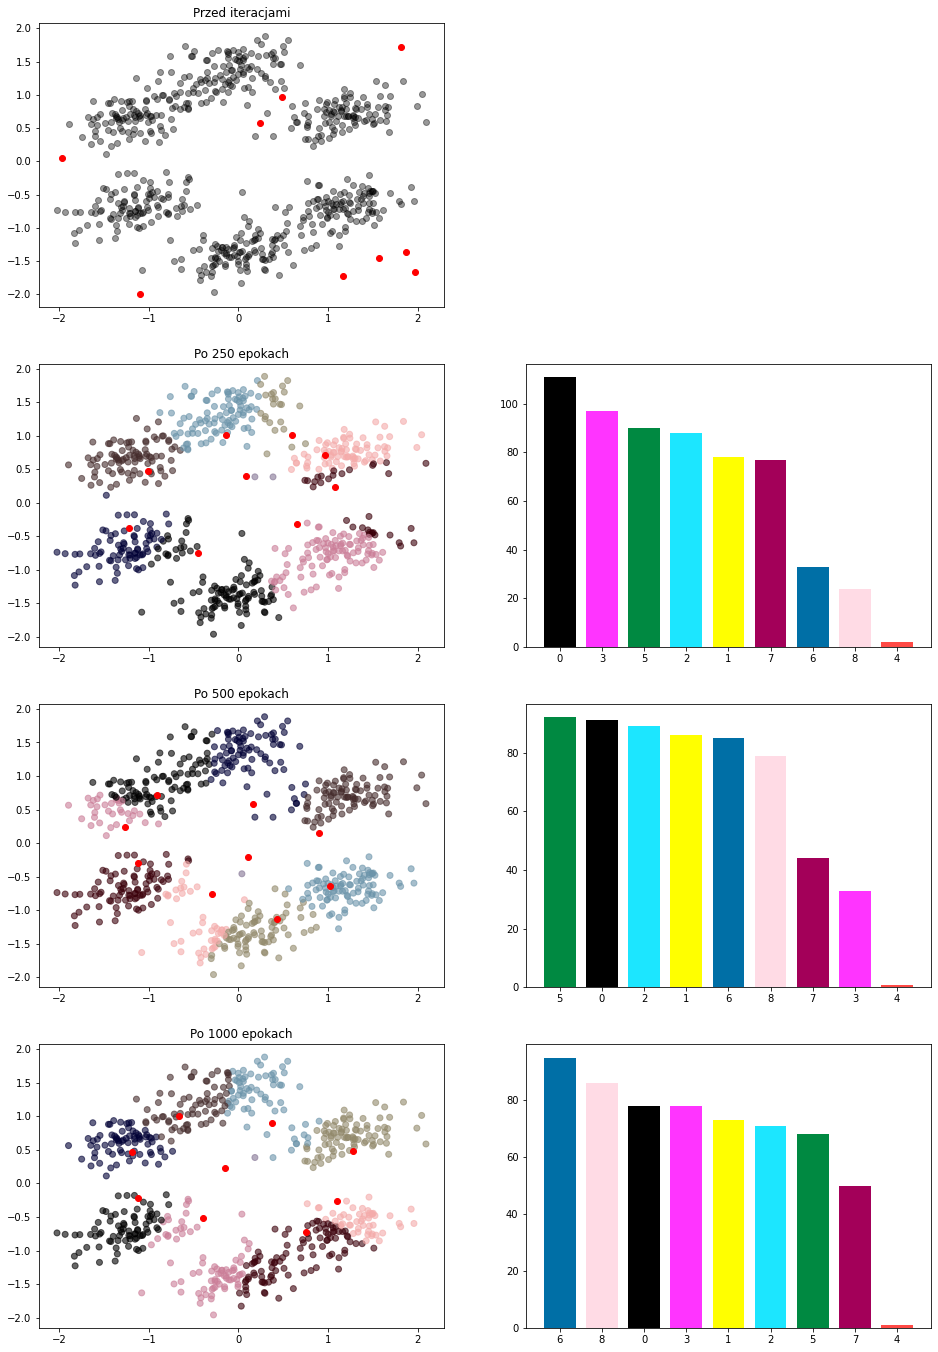

In [160]:
koh = kohonen(3,3,x,1, architecture = "rectangle")

fig = plt.figure(figsize=(16,24))

plt.subplot(4, 2, 1)
plt.scatter(dataset['x'], dataset['y'], color = "black", alpha=0.4)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "red")
plt.title('Przed iteracjami')


koh.learn(lambda_=250, method="gauss")
c = koh.classify()

plt.subplot(4, 2, 3)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.6, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "red")
plt.title('Po 250 epokach')

data = to_dict(c)
plt.subplot(4, 2, 4)
plt.bar([str(key) for key in list(data.keys())], data.values(), 0.75, color=[colors[i] for i in list(data.keys())])

koh.learn(lambda_=250, method="gauss")
c = koh.classify()

plt.subplot(4, 2, 5)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.6, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "red")
plt.title('Po 500 epokach')

data = to_dict(c)
plt.subplot(4, 2, 6)
plt.bar([str(key) for key in list(data.keys())], data.values(), 0.75, color=[colors[i] for i in list(data.keys())])

koh.learn(lambda_=5000, method="gauss")
c = koh.classify()

plt.subplot(4, 2, 7)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.6, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "red")
plt.title('Po 1000 epokach')

data = to_dict(c)
plt.subplot(4, 2, 8)
plt.bar([str(key) for key in list(data.keys())], data.values(), 0.75, color=[colors[i] for i in list(data.keys())])


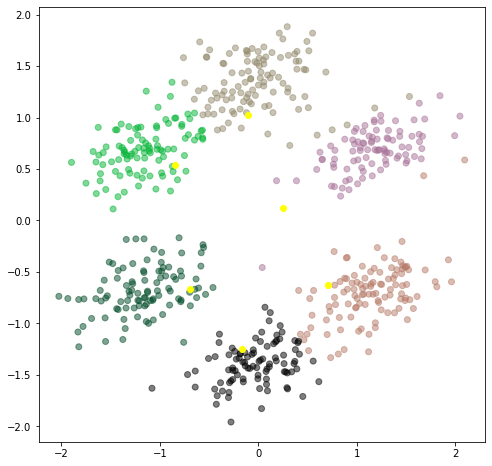

In [122]:
koh.learn(lambda_=10, method="gauss")
c = koh.classify()

fig = plt.figure(figsize=(8,8))

plt.scatter(dataset['x'], dataset['y'], c=c, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "yellow")

In [120]:
colors = [

        "#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",

        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58",
        
        "#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D",
        "#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176",
        "#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5",
        "#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4",
        "#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01",
        "#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966",
        "#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0",
        "#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C",

        "#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868",
        "#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183",
        "#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433",
        "#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F",
        "#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E",
        "#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F",
        "#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00",
        "#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66",
        
        "#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25",
        "#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B"
]

### Cube 

In [28]:
dataset = pd.read_csv('cube.csv')
x = np.asarray(dataset.iloc[:,[0,1,2]])

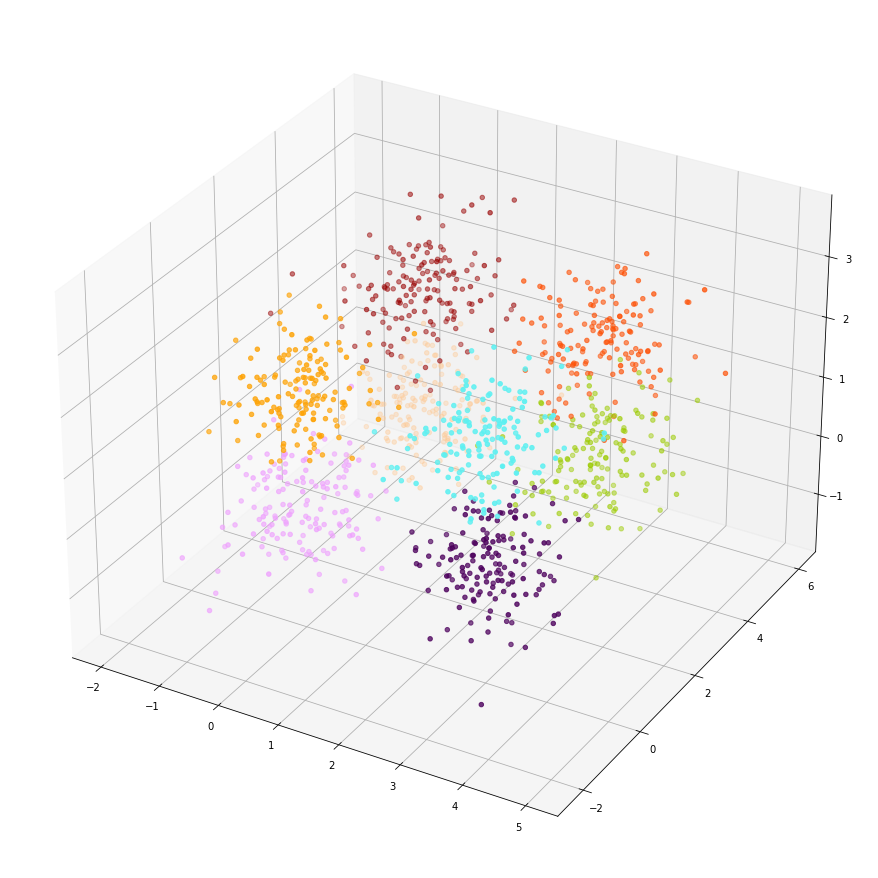

In [30]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=dataset['c'], cmap=matplotlib.colors.ListedColormap(colors))

In [31]:
koh = kohonen(5,5,x,1)
koh.neurons
koh.learn(lambda_=300, method="gauss")
c = koh.classify()

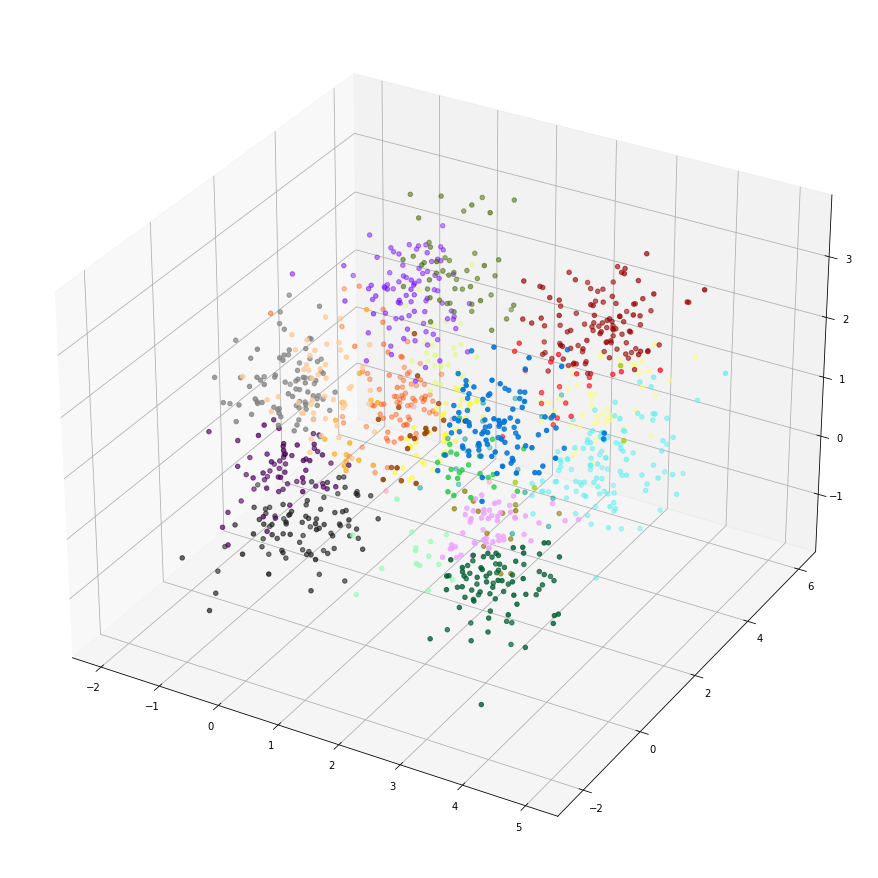

In [32]:
fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c, cmap=matplotlib.colors.ListedColormap(colors))

In [111]:
np.random.uniform(5,10, size=(3*5,2,3))

array([[[5.08806656, 8.36384395, 9.27770564],
        [6.68442499, 6.66824816, 9.94565298]],

       [[7.76169951, 6.39671049, 7.9959639 ],
        [7.90078547, 8.13133815, 6.29278636]],

       [[8.2458864 , 7.465801  , 7.23921933],
        [7.30314785, 6.6471244 , 9.44530039]],

       [[6.54500408, 8.85792007, 7.20357816],
        [8.28466399, 5.2781896 , 6.17771182]],

       [[6.93186701, 9.19780941, 6.50409099],
        [7.61133744, 7.86042298, 8.06949724]],

       [[7.33938452, 6.79067138, 7.56271506],
        [8.19102671, 6.7857448 , 5.05154259]],

       [[7.51300573, 8.41265004, 8.11046824],
        [7.17216959, 9.33248848, 8.60592714]],

       [[7.05827518, 7.74250619, 6.05024948],
        [8.12897252, 8.27912723, 6.86631532]],

       [[5.50692132, 6.78971714, 5.34623535],
        [9.67228189, 6.47867157, 7.14937278]],

       [[8.40493755, 6.35840508, 7.88935856],
        [9.69527662, 5.48914145, 5.72370747]],

       [[6.21238891, 6.39880987, 9.71857776],
        [6.241